In [1]:
import tushare as ts
import time
import datetime
import sys
import os
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
sys.path.append('../Codes')
import DataProcessor as DP
from DataProcessor import centralize
from DataProcessor import standardize
from DataProcessor import standardize_industry
from DataProcessor import get_industrys
from DataProcessor import get_all_industrys
from DataProcessor import get_stock_daily_data
from DataProcessor import get_stock_money_data
from DataProcessor import get_index_data
import tools

In [2]:
pro = ts.pro_api()

In [3]:
#获取行业分类
industrys = DP.get_all_industrys()

In [474]:
industry = ['801750.SI', '801740.SI', '801080.SI',]

#取行业内股票数据
data = DP.get_stock_daily_data(industrys=industrys,
                               industry=industry,
                         fields=['open',
                                 'high',
                                 'low',
                                 'close',
                                 'vol',
                                 'amount',
                                 'adj_factor',
                                 'turnover_rate_f',
                                 'pe_ttm',
                                 'pb',
                                 'ps_ttm',
                                 'dv_ttm',
                                 'total_mv'])

money_dic = get_stock_money_data(industrys, industry)
for k in money_dic.keys():
    money_dic[k] = DataFrame(money_dic[k], index=data['open'].index, columns=data['open'].columns)

In [475]:
st = DP.get_st_data(industrys, industry, data['open'])

In [484]:
#因子构造
OPEN = np.log(data['open'] * data['adj_factor'])
HIGH = np.log(data['high'] * data['adj_factor'])
LOW = np.log(data['low'] * data['adj_factor'])
CLOSE = np.log(data['close'] * data['adj_factor'])

vol = data['vol']
amount = data['amount']

vwap = np.log(amount / vol * data['adj_factor'])

trf = data['turnover_rate_f']
ltrf = np.log(trf)

mv = data['total_mv']
lmv = np.log(mv)

pe = data['pe_ttm']
pb = data['pb']
ps = data['ps_ttm']
pe = 1 / pe
ps = 1 / ps
pb = 1 / pb

dv = data['dv_ttm']

rzrqye = (money_dic['rzye'].fillna(method='ffill') - money_dic['rqye'].fillna(method='ffill')).fillna(method='ffill').loc[OPEN.index, :].fillna(method='ffill')
gt = money_dic['gt_vol'].fillna(method='ffill').loc[OPEN.index, :].fillna(method='ffill')
d_rzrq = rzrqye / rzrqye.shift()
d_rzrq.fillna(1, inplace=True)
d_gt = gt / gt.shift()
d_gt.fillna(1, inplace=True)

In [485]:
ror = CLOSE - CLOSE.shift()
r_rinei = CLOSE - OPEN
r_geye = OPEN - CLOSE.shift()
rh = HIGH - OPEN
rl = LOW - OPEN
hl = rh - rl
vr = ltrf - ltrf.shift()

In [486]:
n = 1
y = standardize_industry(OPEN.shift(-n)-OPEN, industrys, industry)
y[(r_geye > 0.09).fillna(False) & (r_rinei.abs() < 1e-6).fillna(False)] = 0

In [557]:
x1 = standardize_industry(r_rinei, industrys, industry)
x2 = standardize_industry(r_rinei.rolling(1).sum().shift(1), industrys, industry)
x3 = standardize_industry(r_rinei.rolling(3).sum().shift(2), industrys, industry)
x4 = standardize_industry(r_rinei.rolling(5).sum().shift(5), industrys, industry)
x5 = standardize_industry(r_rinei.rolling(10).sum().shift(10), industrys, industry)

z1 = standardize_industry(r_geye, industrys, industry)
z2 = standardize_industry(r_geye.rolling(1).sum().shift(1), industrys, industry)
z3 = standardize_industry(r_geye.rolling(3).sum().shift(2), industrys, industry)
z4 = standardize_industry(r_geye.rolling(5).sum().shift(5), industrys, industry)
z5 = standardize_industry(r_geye.rolling(10).sum().shift(10), industrys, industry)

m1 = standardize_industry(CLOSE/CLOSE.rolling(3).mean(), industrys, industry)
m2 = standardize_industry(CLOSE/CLOSE.rolling(5).mean(), industrys, industry)
m3 = standardize_industry(CLOSE/CLOSE.rolling(10).mean(), industrys, industry)
m4 = standardize_industry(CLOSE/CLOSE.rolling(20).mean(), industrys, industry)
m5 = standardize_industry(CLOSE/CLOSE.rolling(40).mean(), industrys, industry)

u1 = x1 - z1
u2 = x2 - z2
u3 = x3 - z3
u4 = x4 - z4
u5 = x5 - z5

r1 = x1 + z1
r2 = x2 + z2
r3 = x3 + z3
r4 = x4 + z4
r5 = x5 + z5

h1 = standardize_industry(rh, industrys, industry)
h2 = standardize_industry(rh.rolling(1).sum().shift(1), industrys, industry)
h3 = standardize_industry(rh.rolling(3).sum().shift(2), industrys, industry)
h4 = standardize_industry(rh.rolling(5).sum().shift(5), industrys, industry)
h5 = standardize_industry(rh.rolling(10).sum().shift(10), industrys, industry)

l1 = standardize_industry(rl, industrys, industry)
l2 = standardize_industry(rl.rolling(1).sum().shift(1), industrys, industry)
l3 = standardize_industry(rl.rolling(3).sum().shift(2), industrys, industry)
l4 = standardize_industry(rl.rolling(5).sum().shift(5), industrys, industry)
l5 = standardize_industry(rl.rolling(10).sum().shift(10), industrys, industry)

hl1 = h1 - l1
hl2 = h2 - l2
hl3 = h3 - l3
hl4 = h4 - l4
hl5 = h5 - l5

ch1 = x1 - h1
ch2 = x2 - h2
ch3 = x3 - h3
ch4 = x4 - h4
ch5 = x5 - h5

cl1 = x1 - l1
cl2 = x2 - l2
cl3 = x3 - l3
cl4 = x4 - l4
cl5 = x5 - l5


vr1 = standardize_industry(vr, industrys, industry)
vr2 = standardize_industry(vr.rolling(1).sum().shift(1), industrys, industry)
vr3 = standardize_industry(vr.rolling(3).sum().shift(2), industrys, industry)
vr4 = standardize_industry(vr.rolling(5).sum().shift(5), industrys, industry)
vr5 = standardize_industry(vr.rolling(10).sum().shift(10), industrys, industry)


rzrq1 = standardize_industry(d_rzrq, industrys, industry).fillna(0)
rzrq2 = standardize_industry(d_rzrq.rolling(1).sum().shift(1), industrys, industry).fillna(0)
rzrq3 = standardize_industry(d_rzrq.rolling(3).sum().shift(2), industrys, industry).fillna(0)
rzrq4 = standardize_industry(d_rzrq.rolling(5).sum().shift(5), industrys, industry).fillna(0)
rzrq5 = standardize_industry(d_rzrq.rolling(10).sum().shift(10), industrys, industry).fillna(0)

gt1 = standardize_industry(d_gt, industrys, industry).fillna(0)
gt2 = standardize_industry(d_gt.rolling(1).sum().shift(1), industrys, industry).fillna(0)
gt3 = standardize_industry(d_gt.rolling(3).sum().shift(2), industrys, industry).fillna(0)
gt4 = standardize_industry(d_gt.rolling(5).sum().shift(5), industrys, industry).fillna(0)
gt5 = standardize_industry(d_gt.rolling(10).sum().shift(10), industrys, industry).fillna(0)

pe = standardize_industry(pe, industrys, industry)
pb = standardize_industry(pb, industrys, industry)
ps = standardize_industry(ps, industrys, industry)

lmv = standardize_industry(lmv, industrys, industry)

ao1 = standardize_industry(vwap-OPEN, industrys, industry)
ao2 = standardize_industry((vwap-OPEN).shift(), industrys, industry)
ca1 = standardize_industry(CLOSE-vwap, industrys, industry)
ca2 = standardize_industry((CLOSE-vwap).shift(), industrys, industry)

dv = standardize_industry(dv, industrys, industry)

In [563]:
factor = {
    'x1':x1, 'x2':x2, 'x3':x3, 'x4':x4, 'x5':x5,
    'z1':z1, 'z2':z2, 'z3':z3, 'z4':z4, 'z5':z5,
    'u1':u1, 'u2':u2, 'u3':u3, 'u4':u4, 'u5':u5,#没啥用
    'r1':r1, 'r2':r2, 'r3':r3, 'r4':r4, 'r5':r5,#多余
    'h1':h1, 'h2':h2, 'h3':h3, 'h4':h4, 'h5':h5,#估计没ch好用
    'l1':l1, 'l2':l2, 'l3':l3, 'l4':l4, 'l5':l5,#同下
    'ch1':ch1, 'ch2':ch2, 'ch3':ch3, 'ch4':ch4, 'ch5':ch5,#试试看
    'cl1':cl1, 'cl2':cl2, 'cl3':cl3, 'cl4':cl4, 'cl5':cl5,#试试看
    'hl1':hl1, 'hl2':hl2, 'hl3':hl3, 'hl4':hl4, 'hl5':hl5,#逻辑不好
    'ao1':ao1, 'ao2':ao2,
    'ca1':ca1, 'ca2':ca2,
    'm1':m1, 'm2':m2, 'm3':m3, 'm4':m4, 'm5':m5,
    'vr1':vr1, 'vr2':vr2, 'vr3':vr3, 'vr4':vr4, 'vr5':vr5,
    'rzrq1':rzrq1, 'rzrq2':rzrq2, 'rzrq3':rzrq3, 'rzrq4':rzrq4, 'rzrq5':rzrq5,
    'gt1':gt1, 'gt2':gt2, 'gt3':gt3, 'gt4':gt4, 'gt5':gt5,
    'pe':pe, 'pb':pb, 'ps':ps,
    'dv':dv,
    'lmv':lmv,
}

In [564]:
for k in factor.keys():
    df = DataFrame(factor[k])
    df[st] = 0
    #df[st] = DataFrame({stock:df.mean(1) for stock in df.columns})
    factor[k] = DataFrame(df)

In [551]:
#ic, ir = tools.icir(pe.shift(), y, n=60, rank=True)
#ir.plot()

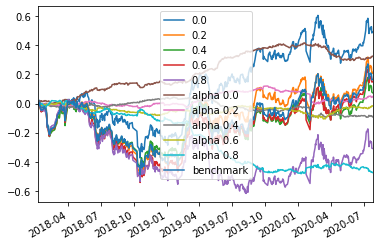

In [552]:
tools.group_backtest((ao).shift().iloc[-620:,:], ((OPEN.shift(-n)-OPEN) / n).iloc[-620:,:], n=5)

In [565]:
begin_date = '2012-01-01'
split_date = '2018-01-01'
train_date = y.index[(begin_date < y.index) & (y.index < split_date)]
test_date = y.index[y.index > split_date]

In [566]:
df_y_train = DataFrame({'y':y.loc[train_date, :].values.flatten()})
df_x_train = DataFrame({k:factor[k].loc[train_date, :].shift().values.flatten() for k in factor.keys()})
df_y_test = DataFrame({'y':y.loc[test_date, :].values.flatten()})
df_x_test = DataFrame({k:factor[k].loc[test_date, :].shift().values.flatten() for k in factor.keys()})
df_train = pd.concat([df_y_train, df_x_train], axis=1)
df_test = pd.concat([df_y_test, df_x_test], axis=1)

In [609]:
model = smf.ols('y~ca1\
                  +ao1\
                  +z1\
                  +pe\
                  +lmv', data=df_train).fit()
model.tvalues

Intercept   -12.298096
ca1         -23.869423
ao1           6.615450
z1            3.703385
pe            9.793095
lmv         -12.329706
dtype: float64

300543.SZ    0.091268
000541.SZ    0.072762
300231.SZ    0.072022
300657.SZ    0.069752
300034.SZ    0.069473
300373.SZ    0.064530
300719.SZ    0.063337
300077.SZ    0.062966
300542.SZ    0.062565
300520.SZ    0.059760
Name: 2017-12-29 00:00:00, dtype: float64


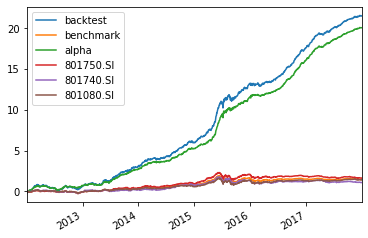

In [610]:
#调仓周期
y_hat = DataFrame(model.predict(df_train).values.reshape(len(train_date), len(y.columns)), index=train_date, columns=y.columns)
q = 0.98
position = (y_hat.gt(y_hat.quantile(q, 1), 0)) & (y_hat.lt(y_hat.quantile(1, 1), 0))

ror_train = ror.loc[train_date, :]
r_rinei_train = r_rinei.loc[train_date, :]
r_geye_train = r_geye.loc[train_date, :]

ror_huice = (position * (OPEN.shift(-n) - OPEN).loc[train_date, :] / n).mul(len(y.columns) / position.sum(1), 0)
ror_huice.mean(1).cumsum().plot()

benchmark = ror_train
benchmark.mean(1).cumsum().plot()

alpha = ror_huice.mean(1).cumsum() - benchmark.mean(1).cumsum()
alpha.plot()
for i in industry:
    stock = industrys[i]
    ror_train.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark', 'alpha'] + [i for i in industry])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

In [611]:
position.sum(1)

2012-01-04    0
2012-01-05    5
2012-01-06    5
2012-01-09    5
2012-01-10    5
             ..
2017-12-25    8
2017-12-26    8
2017-12-27    8
2017-12-28    8
2017-12-29    8
Length: 1458, dtype: int64

002664.SZ    0.146488
300458.SZ    0.118617
002869.SZ    0.117607
002177.SZ    0.114365
300552.SZ    0.112406
002045.SZ    0.084364
002449.SZ    0.084085
603636.SH    0.081293
300771.SZ    0.071072
002866.SZ    0.063926
Name: 2020-07-28 00:00:00, dtype: float64


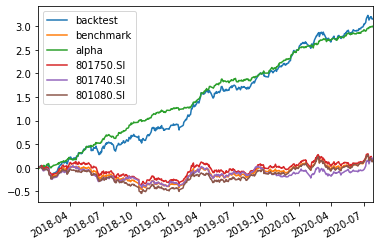

In [617]:
#调仓周期
y_hat = DataFrame(model.predict(df_test).values.reshape(len(test_date), len(y.columns)), index=test_date, columns=y.columns)
q1 = 0.98
q2 = 1
position = (y_hat.gt(y_hat.quantile(q1, 1), 0)) & (y_hat.lt(y_hat.quantile(q2, 1), 0))

ror_test = ror.loc[test_date, :]
r_rinei_test = r_rinei.loc[test_date, :]
r_geye_test = r_geye.loc[test_date, :]

#ror_huice = (position * (OPEN.shift(-n) - OPEN).loc[test_date, :] / n).mul(len(y.columns) / position.sum(1), 0)

ror_huice = (position * (CLOSE - OPEN).loc[test_date, :] + position.shift() * (OPEN - CLOSE.shift()).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0)

#ror_huice = (position * (CLOSE - OPEN).loc[test_date, :] + position.shift() * (CLOSE - CLOSE.shift()).loc[test_date, :] + position.shift(2) * (OPEN - CLOSE.shift()).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0) / 2


ror_huice.mean(1).cumsum().plot()

benchmark = ror_test
benchmark.mean(1).cumsum().plot()

alpha = ror_huice.mean(1).cumsum() - benchmark.mean(1).cumsum()
alpha.plot()
for i in industry:
    stock = industrys[i]
    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark', 'alpha'] + [i for i in industry])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

In [618]:
position.sum(1)

2018-01-02    0
2018-01-03    8
2018-01-04    8
2018-01-05    8
2018-01-08    8
             ..
2020-07-22    9
2020-07-23    9
2020-07-24    9
2020-07-27    9
2020-07-28    9
Length: 624, dtype: int64

In [620]:
ror_huice.mean(1).iloc[-5:]

2020-07-22    0.015932
2020-07-23   -0.006485
2020-07-24   -0.038527
2020-07-27    0.001362
2020-07-28   -0.010046
dtype: float64

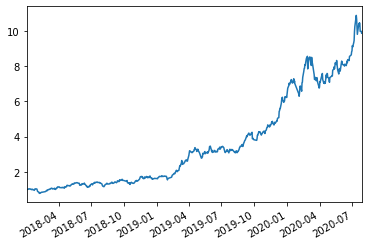

In [621]:
(ror_huice.mean(1)-0.001+1).cumprod().plot()

In [622]:
ror_huice.mean(1).mean() / ror_huice.mean(1).std() * np.sqrt(len(ror_huice))

4.641450368267663

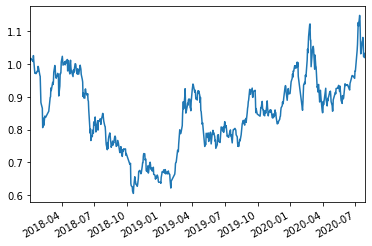

In [623]:
(benchmark.mean(1)+1).cumprod().plot()

In [624]:
df_y_test2 = DataFrame({'y':y.loc[test_date, :].values.flatten()})
df_x_test2 = DataFrame({k:factor[k].loc[test_date, :].values.flatten() for k in factor.keys()})
df_test2 = pd.concat([df_y_test2, df_x_test2], axis=1)
y_hat2 = DataFrame(model.predict(df_test2).values.reshape(len(ror_test), len(ror_test.columns)), index=ror_test.index, columns=ror_test.columns)
print(y_hat2.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

002937.SZ    0.103415
300726.SZ    0.085636
300582.SZ    0.074704
300424.SZ    0.071901
300462.SZ    0.071437
002861.SZ    0.069755
002045.SZ    0.068010
300123.SZ    0.067406
603327.SH    0.064785
002771.SZ    0.061330
Name: 2020-07-28 00:00:00, dtype: float64


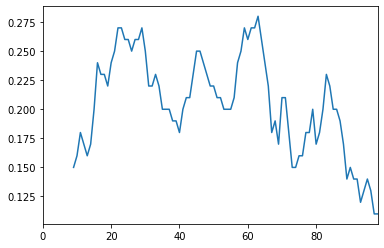

In [633]:
Series([len(y_hat2.iloc[-i,:].sort_values(ascending=False).dropna().iloc[:10].index & y_hat2.iloc[-i-1,:].sort_values(ascending=False).dropna().iloc[:10].index)/10 for i in range(1,100)]).rolling(10).mean().plot()

In [368]:
model = RandomForestRegressor(n_estimators=10).fit(df_train.iloc[:, 1:], df_train.iloc[:, 0])
model.feature_importances_

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [386]:
Series([1,2,3]).rename('1').name

'1'

In [387]:
factor = DataFrame(np.arange(12).reshape(3,4))

In [404]:
factor.apply(lambda a:Series(rankdata(a)), axis=1)

,0,1,2,3
0,4.0,1.0,2.0,3.0
1,1.0,2.0,3.0,4.0
2,1.0,2.0,3.0,4.0


In [390]:
factor.iloc[0,0] = 100

In [393]:
factor

,0,1,2,3
0,100,1,2,3
1,4,5,6,7
2,8,9,10,11


In [398]:
a=[200, 1,2,3]

In [399]:
sorted(range(len(a)), key = a.__getitem__)

[1, 2, 3, 0]

In [400]:
from scipy.stats import rankdata

In [401]:
rankdata(a)

array([4., 1., 2., 3.])

In [403]:
rankdata(factor)

array([12.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [409]:
s = Series([1,2]).rename(11)

In [410]:
DataFrame(s)

,11
0,1
1,2


In [622]:
df = DataFrame(np.arange(12).reshape(3,4))

In [623]:
df2 = df + 1

In [627]:
df2.divide(df)

,0,1,2,3
0,inf,2.000000,1.500000,1.333333
1,1.250,1.200000,1.166667,1.142857
2,1.125,1.111111,1.100000,1.090909


In [671]:
df = pro.us_basic()

In [672]:
df

,ts_code,name,classify,list_date,delist_date
0,ONCY,None,EQT,20011005,None
1,SCCO,None,EQT,19950124,None
2,KAOCF,None,EQT,19740319,None
3,BOIRF,None,EQT,19880628,None
4,SDXOF,None,EQT,19830304,None
...,...,...,...,...,...
5995,ESESQ,None,EQT,20031014,None
5996,TRKX,None,EQT,20000718,None
5997,ELAMF,None,EQT,19960320,None
5998,CZNB,None,EQT,20120724,None


In [680]:
O = DataFrame()
C = DataFrame()
for stock in df.ts_code:
    tmp = pro.us_daily(ts_code=stock, start_date='20100101', end_date='20200101').set_index('trade_date')
    time.sleep(30)
    O.loc[:,stock] = tmp.open
    C.loc[:,stock] = tmp.close

KeyboardInterrupt: 

In [689]:
C.fillna(method='ffill')

,ONCY,SCCO,KAOCF,BOIRF,SDXOF,ODMUF,CHJHF,DBOXF,IMNPQ,CYUFF,...,ABCE,BWEN,PYT,ICBT,HOSZY,ICE,AQSP,YHDT,OSUR,PSBQ
trade_date,,,,,,,,,,,,,,,,,,,,,
20191231,4.76,42.48,NaN,NaN,NaN,NaN,0.55,0.08,0.00,NaN,...,0.00,1.66,NaN,NaN,NaN,92.55,2.50,NaN,8.03,27.50
20191230,3.87,42.49,NaN,NaN,NaN,NaN,0.40,0.08,0.00,NaN,...,0.00,1.65,NaN,NaN,NaN,92.44,2.77,NaN,7.81,27.50
20191227,2.84,42.57,NaN,NaN,NaN,NaN,0.40,0.08,0.00,NaN,...,0.00,1.65,23.13,NaN,NaN,93.00,2.70,NaN,7.92,27.50
20191226,2.82,43.19,NaN,NaN,NaN,NaN,0.40,0.09,0.00,NaN,...,0.00,1.69,22.33,NaN,NaN,92.87,2.70,NaN,8.01,27.50
20191224,1.83,42.59,NaN,NaN,NaN,NaN,0.40,0.09,0.00,NaN,...,0.00,1.70,22.99,NaN,NaN,92.19,2.51,NaN,8.29,27.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20100108,2.94,36.26,24.74,45.9,58.48,1.64,0.47,0.34,0.64,2.85,...,0.02,7.34,18.74,0.0,NaN,108.48,3.25,0.2,4.95,16.50
20100107,2.87,35.56,24.74,45.9,58.15,1.64,0.47,0.34,0.64,2.85,...,0.02,7.43,18.73,0.0,NaN,108.14,3.25,0.2,4.88,16.50
20100106,2.92,35.90,24.74,45.9,60.23,1.64,0.47,0.34,0.63,2.85,...,0.02,7.05,18.45,0.0,NaN,105.27,3.25,0.2,4.94,15.05


In [695]:
O=O.sort_index()
C=C.sort_index()

In [717]:
rgeye=(O/C.shift()-1).fillna(0)
rgeye[rgeye==np.inf]=0
rgeye[rgeye>5]=0
rgeye[rgeye<-5]=0

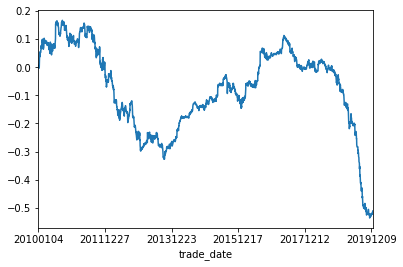

In [718]:
rgeye.mean(1).cumsum().plot()

In [704]:
rgeye.max()

ONCY     9.189189
SCCO     0.050389
KAOCF    0.048622
BOIRF    0.025781
SDXOF    0.113889
           ...   
ICE      0.058221
AQSP     1.750000
YHDT     1.352941
OSUR     0.214545
PSBQ     0.166667
Length: 77, dtype: float64

In [688]:
rgeye

,ONCY,SCCO,KAOCF,BOIRF,SDXOF,ODMUF,CHJHF,DBOXF,IMNPQ,CYUFF,...,ABCE,BWEN,PYT,ICBT,HOSZY,ICE,AQSP,YHDT,OSUR,PSBQ
trade_date,,,,,,,,,,,,,,,,,,,,,
20191231,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0,0.000000,0.000000,0.0,0.000000,0.000000
20191230,-0.399160,0.002119,0.0,0.0,0.000000,0.0,-0.272727,-0.125,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0,0.005727,0.108000,0.0,-0.012453,-0.014182
20191227,-0.320413,0.020946,0.0,0.0,0.000000,0.0,0.000000,0.000,0.000000,0.0,...,0.0,0.024242,0.000000,0.0,0,0.006166,-0.025271,0.0,0.029449,-0.007273
20191226,-0.348592,0.004933,0.0,0.0,0.000000,0.0,0.000000,0.000,0.000000,0.0,...,0.0,0.042424,-0.009511,0.0,0,-0.005806,0.000000,0.0,0.049242,0.000000
20191224,-0.375887,-0.009030,0.0,0.0,0.000000,0.0,0.000000,0.000,0.000000,0.0,...,0.0,0.029586,0.029557,0.0,0,-0.005061,0.125926,0.0,0.049938,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20100108,-0.003436,-0.019559,0.0,0.0,0.000000,0.0,0.000000,0.000,-0.247059,0.0,...,0.0,0.031989,0.005365,0.0,0,-0.007281,0.000000,0.0,-0.043222,0.000000
20100107,-0.013605,-0.015168,0.0,0.0,-0.005643,0.0,0.000000,0.000,0.000000,0.0,...,0.0,-0.038147,-0.012807,0.0,0,-0.034200,0.000000,0.0,0.000000,0.000000
20100106,0.020906,-0.014904,0.0,0.0,0.037317,0.0,0.000000,0.000,-0.031250,0.0,...,0.0,0.014805,-0.034170,0.0,0,-0.008692,0.000000,0.0,0.043033,0.000000
